## Periphery Structure

In this section, we identify the **periphery nodes** in the network — these are the most distant nodes in terms of shortest path length. They lie on the edge of the graph, having the highest eccentricity.

These nodes often represent **isolated or niche playlists** that are less integrated with the core of the network.

We used NetworkX's built-in `eccentricity` and `periphery` functions to extract these nodes and highlighted them in red in the network visualization.


In [1]:
import sys
sys.path.append('../')

import utils
import networkx as nx
import matplotlib as mpl
import seaborn as sns
import numpy as np
from networkx.algorithms.community import greedy_modularity_communities
from collections import Counter
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as patches


np.random.seed(42)
plt.style.use('../style.mpl')

In [2]:
# Load the network graph from file and print basic info
G = utils.load_network(path="../data/network.pkl")
print(G)

Graph with 1139 nodes and 17908 edges


In [3]:
communities = list(greedy_modularity_communities(G))
for idx, members in enumerate(communities):
    print(f"\nCommunity {idx+1} — {len(members)} artists:")
    print(", ".join(sorted(members)))
    print("-" * 80)

print(f"Detected {len(communities)} communities")


Community 1 — 428 artists:
#1 Dads, 2 Chainz, 21 Savage, 311, 50 Cent, 6LACK, A Boogie Wit da Hoodie, A R I Z O N A, A$AP Ferg, A$AP Rocky, Ace Hood, Action Bronson, Adele, Aer, Akon, Alan Walker, Alessia Cara, Alesso, Alex Newell, Alina Baraz, Alok, Amber Run, Aminé, Andy Grammer, Arctic Monkeys, Ariana Grande, Atreyu, Audien, Autograf, Avenged Sevenfold, Avicii, Avid Dancer, Avril Lavigne, B.o.B, BABE, Baby Bash, Bad Meets Evil, Bas, Bastille, Bebe Rexha, Beck, Beyoncé, Big Sean, Birdy, Blackstreet, Bobby Brackins, Bobby Shmurda, Bombay Bicycle Club, Brad Paisley, Brandy, Britney Spears, Bruce Springsteen, Bruno Mars, Bryson Tiller, BØRNS, CAZZETTE, Ca$h Out, Calvin Harris, Cash Cash, Chance The Rapper, Charlie Puth, Chet Faker, Chief Keef, Childish Gambino, Chose, Chris Brown, Clean Bandit, Coast Modern, Cold Chisel, Cold War Kids, Coldplay, Collective Soul, Colony House, Crowded House, Cypress Hill, DJ Drama, DJ Khaled, DJ Snake, DRAM, DVBBS, Daniel Caesar, Daniel Powter, Daryl Ha

In [4]:
periphery_nodes = nx.periphery(G)
print(f"Found {len(periphery_nodes)} periphery nodes.")

communities = list(greedy_modularity_communities(G))
print(f"Detected {len(communities)} communities")

node_to_community = {}
for community_idx, community_members in enumerate(communities):
    for node in community_members:
        node_to_community[node] = community_idx

periphery_community_ids = [node_to_community[node] for node in periphery_nodes]
count_by_community = Counter(periphery_community_ids)

print("Periphery nodes by community:")
for comm_id, count in count_by_community.most_common():
    print(f"Community {comm_id}: {count} periphery nodes")

Found 10 periphery nodes.
Detected 11 communities
Periphery nodes by community:
Community 3: 9 periphery nodes
Community 6: 1 periphery nodes


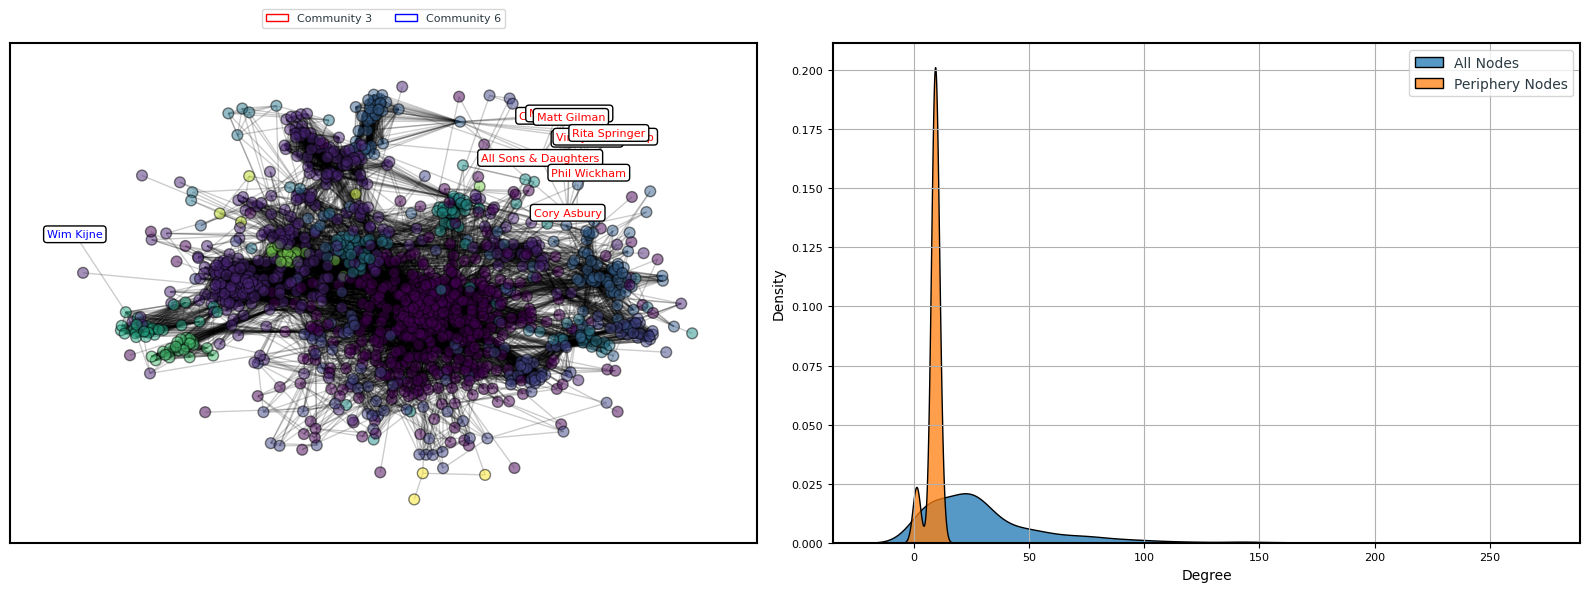

In [75]:
f, axes = plt.subplots(1,2, figsize=(16, 6))

pos = nx.spring_layout(G, seed=42, k=0.3)
node_sizes = [60] * G.number_of_nodes()
cmap = plt.cm.viridis

community6_periphery = [n for n in periphery_nodes if node_to_community[n] == 6]
other_periphery = [n for n in periphery_nodes if node_to_community[n] != 6]
non_periphery_nodes = [n for n in G.nodes() if n not in periphery_nodes]

node_colors = [cmap(node_to_community[n] / max(node_to_community.values())) for n in G.nodes()]

nx.draw_networkx_nodes(
    G, pos,
    nodelist=non_periphery_nodes,
    node_color=[node_colors[list(G.nodes()).index(n)] for n in non_periphery_nodes],
    node_size=[60] * len(non_periphery_nodes),
    edgecolors='black',
    alpha=0.5,
    ax=axes[0]
)

nx.draw_networkx_labels(
    G, pos,
    labels={n: n for n in other_periphery},
    font_size=8,
    font_color='red',
    font_family='sans-serif',
    ax=axes[0],
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

nx.draw_networkx_labels(
    G, pos,
    labels={n: n for n in community6_periphery},
    font_size=8,
    font_color='blue',
    font_family='sans-serif',
    ax=axes[0],
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
)

nx.draw_networkx_edges(G, pos, edge_color='black', alpha=0.2, ax=axes[0])

legend_communities = {
    3: {'color': 'red', 'label': "Community 3"},
    6: {'color': 'blue', 'label': "Community 6"}
}

legend_handles = []
for comm_id, props in legend_communities.items():
    legend_handles.append(
        patches.Patch(edgecolor=props['color'], label=props['label'], facecolor='white')
    )

axes[0].legend(handles=legend_handles, loc='upper center', fontsize=8, frameon=True, bbox_to_anchor=(0.5, 1.08), ncol=2)

deg_dict = dict(G.degree())

periphery_degrees = [deg_dict[n] for n in periphery_nodes]
all_degrees = list(deg_dict.values())

sns.kdeplot(all_degrees, label="All Nodes", ax=axes[1], multiple="stack")
sns.kdeplot(periphery_degrees, label="Periphery Nodes", ax=axes[1], multiple="stack")
axes[1].set_xlabel("Degree")
axes[1].set_ylabel("Density")
axes[1].legend(loc='upper right', frameon=True)
axes[1].grid()

plt.tight_layout()
plt.savefig("../plots/periphery.png", transparent=True)
plt.show()